<a href="https://colab.research.google.com/github/sebkplor/167-Class-Github-Repository/blob/main/UDL_Notebook_8_3_Double_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.3: Double Descent**

This notebook investigates double descent as described in section 8.4 of the book.

It uses the MNIST-1D database which can be found at https://github.com/greydanus/mnist1d

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [3]:
# Run this if you're in a Colab to install MNIST 1D repository
!pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-rq0ut6ty
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-rq0ut6ty
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14665 sha256=cd028bf290dd8d21df49afb179b7edcb2e1f62ef5dd2280bf24e8f37b87a0fea
  Stored in directory: /tmp/pip-ephem-wheel-cache-hh8horlr/wheels/18/40/b6/29381fee9b4c80fdbc304d52bb065a7286bbcca5ca2b8737c0
Successfully built mnist1d


In [4]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d
import random
random.seed(0)

# Try attaching to GPU -- Use "Change Runtime Type to change to GPUT"
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cuda


In [5]:
args = mnist1d.data.get_dataset_args()
args.num_samples = 8000
args.train_split = 0.5
args.corr_noise_scale = 0.25
args.iid_noise_scale=2e-2
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=True)

# Add 15% noise to training labels
for c_y in range(len(data['y'])):
    random_number = random.random()
    if random_number < 0.15 :
        random_int = int(random.random() * 10)
        data['y'][c_y] = random_int

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Dimensionality of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 4000
Dimensionality of each example: 40


In [6]:
# Initialize the parameters with He initialization
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

# Return an initialized model with two hidden layers and n_hidden hidden units at each
def get_model(n_hidden):

  D_i = 40    # Input dimensions
  D_k = n_hidden   # Hidden dimensions
  D_o = 10    # Output dimensions

  # Define a model with two hidden layers
  # And ReLU activations between them
  model = nn.Sequential(
  nn.Linear(D_i, D_k),
  nn.ReLU(),
  nn.Linear(D_k, D_k),
  nn.ReLU(),
  nn.Linear(D_k, D_o))

  # Call the function you just defined
  model.apply(weights_init)

  # Return the model
  return model ;

In [7]:
def fit_model(model, data, n_epoch):

  # choose cross entropy loss function (equation 5.24)
  loss_function = torch.nn.CrossEntropyLoss()
  # construct SGD optimizer and initialize learning rate and momentum
  # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)


  x_train = torch.tensor(data['x'].astype('float32'))
  y_train = torch.tensor(data['y'].transpose().astype('long'))
  x_test= torch.tensor(data['x_test'].astype('float32'))
  y_test = torch.tensor(data['y_test'].astype('long'))

  # load the data into a class that creates the batches
  data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

  for epoch in range(n_epoch):
    # loop over batches
    for i, batch in enumerate(data_loader):
      # retrieve inputs and labels for this batch
      x_batch, y_batch = batch
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward pass -- calculate model output
      pred = model(x_batch)
      # compute the loss
      loss = loss_function(pred, y_batch)
      # backward pass
      loss.backward()
      # SGD update
      optimizer.step()

    # Run whole dataset to get statistics -- normally wouldn't do this
    pred_train = model(x_train)
    pred_test = model(x_test)
    _, predicted_train_class = torch.max(pred_train.data, 1)
    _, predicted_test_class = torch.max(pred_test.data, 1)
    errors_train = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
    errors_test= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
    losses_train = loss_function(pred_train, y_train).item()
    losses_test= loss_function(pred_test, y_test).item()
    if epoch%100 ==0 :
      print(f'Epoch {epoch:5d}, train loss {losses_train:.6f}, train error {errors_train:3.2f},  test loss {losses_test:.6f}, test error {errors_test:3.2f}')

  return errors_train, errors_test


In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

The following code produces the double descent curve by training the model with different numbers of hidden units and plotting the test error.

TODO:

*Before* you run the code, and considering that there are 4000 training examples predict:<br>

1.    At what capacity do you think the training error will become zero?<br>
      Response: At Capacity 100 or 100 hidden variables.

2.   At what capacity do you expect the first minima of the double descent curve to appear?<br>
      Response: I expect the first local minimia to appear around the around 5-10 hidden variables
3. At what capacity do you expect the maximum of the double descent curve to appear?<br>
      Response: I expect the maximum to be at 20-40 hidden variables

In [9]:
# This code will take a while (~30 mins on GPU) to run!  Go and make a cup of coffee!

hidden_variables = np.array([2,4,6,8,10,14,18,22,26,30,35,40,45,50,55,60,70,80,90,100,120,140,160,180,200,250,300,400]) ;

errors_train_all = np.zeros_like(hidden_variables)
errors_test_all = np.zeros_like(hidden_variables)
total_weights_all = np.zeros_like(hidden_variables)

# loop over the dataset n_epoch times
n_epoch = 1000

# For each hidden variable size
for c_hidden in range(len(hidden_variables)):
    print(f'Training model with {hidden_variables[c_hidden]:3d} hidden variables')
    # Get a model
    model = get_model(hidden_variables[c_hidden]) ;
    # Count and store number of weights
    total_weights_all[c_hidden] = count_parameters(model)
    # Train the model
    errors_train, errors_test = fit_model(model, data, n_epoch)
    # Store the results
    errors_train_all[c_hidden] = errors_train
    errors_test_all[c_hidden]= errors_test



Training model with   2 hidden variables
Epoch     0, train loss 2.299950, train error 88.70,  test loss 2.302804, test error 89.32
Epoch   100, train loss 1.907521, train error 72.60,  test loss 1.749823, test error 69.18
Epoch   200, train loss 1.897241, train error 72.20,  test loss 1.726709, test error 68.38
Epoch   300, train loss 1.895113, train error 71.93,  test loss 1.722733, test error 68.60
Epoch   400, train loss 1.894666, train error 71.07,  test loss 1.720824, test error 68.60
Epoch   500, train loss 1.893702, train error 71.03,  test loss 1.719602, test error 68.60
Epoch   600, train loss 1.898668, train error 71.60,  test loss 1.728819, test error 68.25
Epoch   700, train loss 1.894839, train error 71.25,  test loss 1.720508, test error 68.90
Epoch   800, train loss 1.892713, train error 70.82,  test loss 1.719105, test error 68.20
Epoch   900, train loss 1.894227, train error 71.57,  test loss 1.718057, test error 69.12
Training model with   4 hidden variables
Epoch   

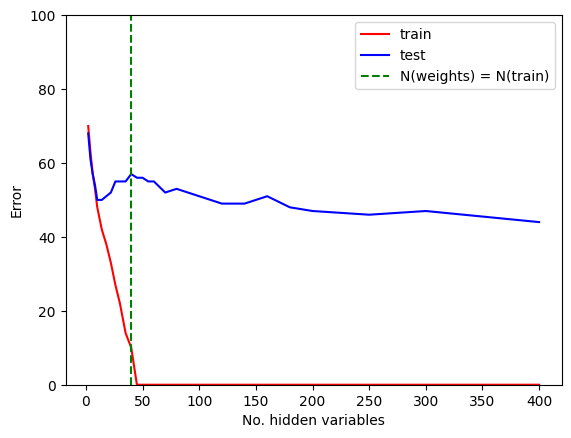

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming data['y'] is available and contains the training examples
num_training_examples = len(data['y'])

# Find the index where total_weights_all is closest to num_training_examples
closest_index = np.argmin(np.abs(np.array(total_weights_all) - num_training_examples))

# Get the corresponding value of hidden variables
hidden_variable_at_num_training_examples = hidden_variables[closest_index]

# Plot the results
fig, ax = plt.subplots()
ax.plot(hidden_variables, errors_train_all, 'r-', label='train')
ax.plot(hidden_variables, errors_test_all, 'b-', label='test')

# Add a vertical line at the point where total weights equal the number of training examples
ax.axvline(x=hidden_variable_at_num_training_examples, color='g', linestyle='--', label='N(weights) = N(train)')

ax.set_ylim(0, 100)
ax.set_xlabel('No. hidden variables')
ax.set_ylabel('Error')
ax.legend()
plt.show()
